## Step 0: Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Step 1: Transform and split the data, investigate distributions of different like thresholds

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

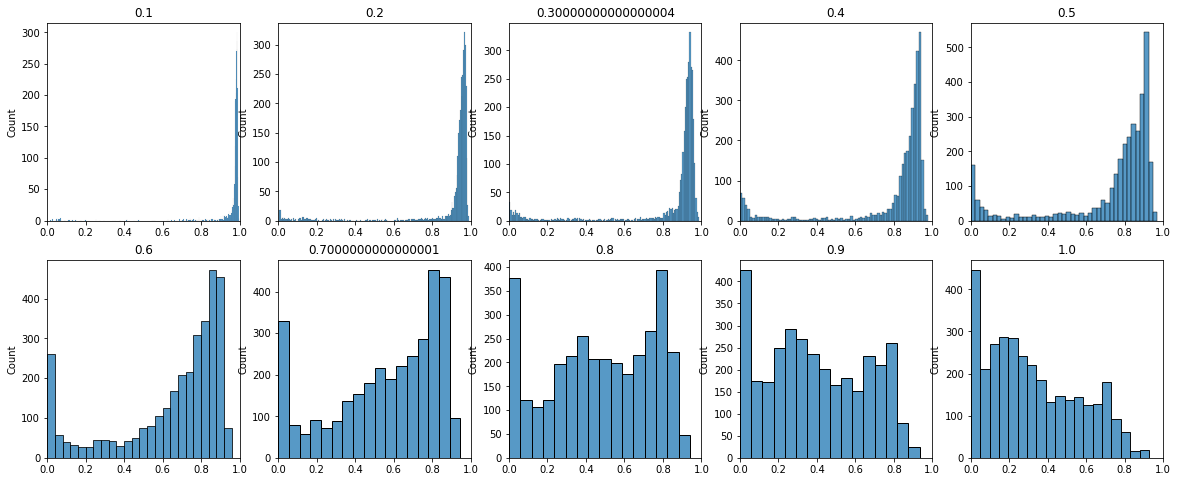

In [3]:
f, axes = plt.subplots(2,5)
f.set_size_inches(20,8)

cutoffs = np.linspace(0.1,1,10)
for i in range(len(cutoffs)):
    c = cutoffs[i]
    ax = (int(i > 4),i % 5)
    temp_df = kuairec_df.copy()
    temp_df['liked'] = kuairec_df['watch_ratio'] > c
    temp_df['liked'] = temp_df['liked'].astype(int)
    video_df = temp_df.groupby(['video_id']).mean()['liked']
    plt.sca(axes[ax[0], ax[1]])
    plt.xlim(0,1)
    sns.histplot(video_df.values).set_title(c)

In [4]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 0.4
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [5]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [6]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [7]:
def transform_values(i,n,prior=1/2):
    return (i*(n-1)+prior)/n

In [8]:
# look up zero-inflated fits for beta, we're throwing out a small fraction of 0-like videos
prior_a, prior_b, loc, scale = beta.fit([transform_values(i, len(train_videos.values),1/2)
                                          for i in train_videos.values], floc=0, fscale=1)

In [9]:
print(prior_a, prior_b)

1.427096589134199 0.5916156493565227


In [10]:
r = beta.rvs(prior_a, prior_b, size=5000)

Text(0.5, 1.0, 'density plot of eb beta prior')

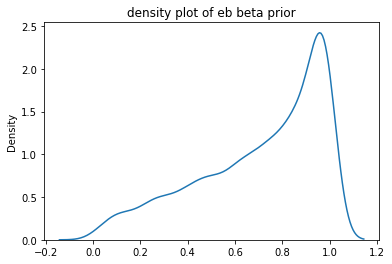

In [11]:
sns.kdeplot(r).set_title('density plot of eb beta prior')

In [12]:
video_df

video_id
103      0.857447
109      0.920624
120      0.928420
122      0.889283
128      0.836286
           ...   
10506    0.937911
10519    0.950925
10552    0.143262
10589    0.906562
10595    0.945266
Name: liked, Length: 3327, dtype: float64

## Step 2: Merge the datasets and select from test set different products

In [13]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [14]:
kuairec_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,liked,like_ratio
0,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,1,0.946137
1,19,183,8033,6100,2020-07-25 09:51:33.664,20200725.0,1.595642e+09,1.316885,1,0.946137
2,21,183,15770,6100,2020-07-08 07:00:20.865,20200708.0,1.594163e+09,2.585246,1,0.946137
3,23,183,20786,6100,2020-07-05 07:50:01.81,20200705.0,1.593907e+09,3.407541,1,0.946137
4,24,183,4737,6100,2020-07-05 03:47:59.561,20200705.0,1.593892e+09,0.776557,1,0.946137


Text(0.5, 1.0, 'histogram of like ratios')

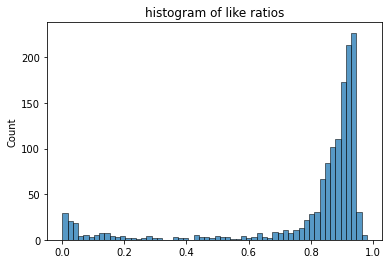

In [15]:
sns.histplot(test_videos.values).set_title('histogram of like ratios')

In [16]:
num_samples = 100

In [17]:
sampled_videos = (list(test_videos.sample(num_samples, random_state=1729).keys()))

In [18]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [19]:
video_df[sampled_videos].sort_values()

video_id
9136    0.002835
8696    0.006383
883     0.008505
7585    0.015603
7566    0.024805
          ...   
858     0.939759
2311    0.942512
6882    0.942594
2687    0.945429
7076    0.950390
Name: liked, Length: 100, dtype: float64

In [20]:
videos_of_interest = video_df[sampled_videos].sort_values()
videos_of_interest = list(videos_of_interest.iloc[[0, num_samples//4, 2*num_samples//4, 3*num_samples//4, -2, -1]].keys())
videos_of_interest

[9136, 9885, 6172, 7257, 2687, 7076]

In [21]:
indices_of_interest = [sampled_videos.index(item) for item in videos_of_interest]

## Step 3: Set up the bandit environment

In [22]:
# set up experiment in a way where we can later interpolate between uninformed prior and eb
uninformed_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2)
eb_priors = np.array([[prior_a]*len(sampled_videos),[prior_b]*len(sampled_videos)]).T
# eb_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2) + np.array([0,1])

In [23]:
def random_argmax(alist):
  maxval = max(alist)
  argmax = [idx for idx, val in enumerate(alist) if val == maxval]
  return np.random.choice(argmax)

def ts_action(actions, num_success, num_failure):
  p_hat = [np.random.beta(num_success[a],num_failure[a]) for a in actions]
  a = random_argmax(p_hat)
  return a

def greedy_action(actions, num_success, num_failure):
  p_hat = [(num_success[a] + 1) / (num_success[a] + num_failure[a] + 2) for a in actions]
  a = random_argmax(p_hat)
  return a

def epsilon_greedy_action(actions, num_success, num_failure):
  if np.random.binomial(1, 0.05):
    a = np.random.choice(actions)
  else:
    a = greedy_action(actions, num_success, num_failure)
  return a

def sample_chosen_df(videos, chosen_df, action_index):
    vid = videos[action_index]
    seen_like = chosen_df[chosen_df['video_id']==vid].sample(1).iloc[0]['liked']
    return seen_like

#### Default multi-armed bandit algorithm

In [24]:
def run_multiarmed_bandit(chosen_df, 
                          videos, 
                          priors, 
                          sampling_action, 
                          timesteps, 
                          num_sims):

    agg_priors_over_time = []
    rewards_over_time = []
    plays = []
    
    for n in range(num_sims):
        if (n+1) % 10 == 0:
            print(f'sim {n+1}/{num_sims}')
            
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        instance_plays = np.zeros(len(videos))
        
        for t in range(timesteps):
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0,:], newest_prior.T[1,:]
            actions = range(len(videos))
            
            a = sampling_action(actions, successes, failures)
            
            instance_plays[a] += 1
            
            like = sample_chosen_df(videos, chosen_df, a)
            
            # update prior
            newest_prior[a,0] += like
            newest_prior[a,1] += 1 - like
            instance_priors_over_time.append(newest_prior)
            
            newest_rewards[a] += like
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        agg_priors_over_time.append(instance_priors_over_time)
        rewards_over_time.append(instance_rewards_over_time)
        plays.append(instance_plays)
        
    agg_priors_over_time = np.stack(agg_priors_over_time)
    rewards_over_time = np.stack(rewards_over_time)
    plays = np.stack(plays)
            
    return agg_priors_over_time, rewards_over_time, plays
            
        

#### Multi-armed bandit with replenishment

In [118]:
class ProductHelper:
    """Class for helping keep track of all the products we have."""
    
    def __init__(self, universe, starting_market, mkt_ids, priors):
        self.universe = universe
        self.mkt_ids = mkt_ids
        self.priors = priors
        self.market = [np.array([copy.deepcopy(self.priors)[k]]) for k in starting_market]
        
    def pull_arm(self, action, like):
        arr = self.market[action]
        latest_action = copy.deepcopy(arr[-1])
        latest_action += np.array([like, 1-like])
        self.market[action] = np.append(arr, [latest_action], axis=0)
        
    def pull_arm_update_market(self, action, like):
        self.pull_arm(action, like)
        for i in range(len(self.market)):
            if not np.array_equal(i, action):
                self.market[i] = np.append(self.market[i], [self.market[i][-1]], axis=0)
        
    def replace_item(self, old_id, new_id):
        old_idx = self.mkt_ids.index(old_id)
        self.universe[old_id].append(copy.deepcopy(self.market[old_idx]))
        self.mkt_ids[old_idx] = new_id
        self.market[old_idx] = np.array([copy.deepcopy(self.priors[new_id])])

In [196]:
def run_multiarmed_bandit_replenishment(chosen_df,
                                        videos,
                                        priors,
                                        sampling_action,
                                        timesteps,
                                        rho,
                                        mkt_size,
                                        num_users=1,
                                        snapshot_start=None,
                                        snapshotting_prob=0.001):
    if not snapshot_start:
        snapshot_start = timesteps//5
    product_data = dict(zip(videos, [[] for _ in range(len(videos))]))
    priors_dict = dict(zip(videos, [priors.copy()[i,:] for i in range(priors.shape[0])]))
    snapshot_dict = dict()
    snapshot_num = 1
            
    curr_vids = np.array(list(np.random.choice(videos, mkt_size, replace=False)))
    remaining_vids = set(videos).difference(set(curr_vids))

    helper = ProductHelper(product_data, curr_vids, list(curr_vids), priors_dict)

    for t in range(timesteps):
        if (t+1) % (timesteps//10) == 0:
            print(f'{t+1}/{timesteps}')
            
        latest_sims = np.array([item[-1] for item in helper.market])
        successes, failures = latest_sims[:,0], latest_sims[:,1]
        actions = range(mkt_size)
        for m in range(num_users):
            a = sampling_action(actions, successes, failures)
            chosen_action_global_index = videos.index(helper.mkt_ids[a])
            like = sample_chosen_df(videos, chosen_df, chosen_action_global_index)

            # update prior
            helper.pull_arm_update_market(a, like)

        # replenish the indices
        flips = np.random.binomial(1, rho, mkt_size)
        draws = np.random.choice(list(remaining_vids), mkt_size, replace=False)

        replenishments = flips * draws
        replaced = flips * helper.mkt_ids
        swapped_pairs = zip(list(replaced[replaced != 0].flatten()), list(replenishments[replenishments != 0].flatten()))
        replenishments = set(replenishments[replenishments != 0].flatten().astype(int))
        replaced = set(replaced[replaced != 0].flatten().astype(int))
        remaining_vids = remaining_vids.union(replaced).difference(replenishments)
        
        # ensure that the remaining videos are distinct size is constant
        if len(list(remaining_vids)) != len(videos) - mkt_size:
            print('remaining_vids', len(list(remaining_vids)))
            print('curr_vids', helper.mkt_ids)
            print('replenishments', replenishments)
            print('replaced', replaced)
            print('flips', flips)
            print('draws', draws)
            assert False

        for old,new in swapped_pairs:
            helper.replace_item(old, new)
            
        if t >= snapshot_start and np.random.binomial(1, snapshotting_prob) > 0:
            snapshot_dict[snapshot_num] = (copy.deepcopy(helper.mkt_ids), copy.deepcopy(helper.market))
            snapshot_num += 1
            
            
    for prod in helper.mkt_ids:
        mkt_idx = helper.mkt_ids.index(prod)
        helper.universe[prod].append(helper.market[mkt_idx])
            
    return helper.universe, snapshot_dict

## Step 4: Run the simulations and save data

In [197]:
timesteps = 300000

In [198]:
uninformed_data, uninf_snapshots = run_multiarmed_bandit_replenishment(kuairec_chosen,
                                                                       sampled_videos,
                                                                       uninformed_priors,
                                                                       ts_action,
                                                                       timesteps=timesteps,
                                                                       rho=0.01,
                                                                       mkt_size=10)

30000/300000
60000/300000
90000/300000
120000/300000
150000/300000
180000/300000
210000/300000
240000/300000
270000/300000
300000/300000


In [199]:
eb_data, eb_snapshots = run_multiarmed_bandit_replenishment(kuairec_chosen,
                                                            sampled_videos,
                                                            eb_priors,
                                                            ts_action,
                                                            timesteps=timesteps,
                                                            rho=0.01,
                                                            mkt_size=10)

30000/300000
60000/300000
90000/300000
120000/300000
150000/300000
180000/300000
210000/300000
240000/300000
270000/300000
300000/300000


## Step 5: Plot and analyze the data from replenishment model

In [200]:
times_of_interest = [0,3,5,50,100,200]

In [201]:
# deprecated, this confidence interval function doesn't really work

# def mean_centered_credible_int(arr):
#     a,b = arr[0], arr[1]
#     mean = a/(a+b)
#     mean_cdf = beta.cdf(mean,a,b)
#     if mean_cdf > 0.525: #we'll have to have a longer left tail
#         left_remainder = 0.95 - (1 - mean_cdf)
#         return (beta.ppf(left_remainder,a,b),1)
#     elif mean_cdf < 0.475: #we'll have to have a longer right tail
#         right_remainder = 0.95 - mean_cdf
#         return (0, beta.ppf(right_remainder,a,b))
#     else:
#         return (beta.ppf(mean_cdf-0.475,a,b), beta.ppf(mean_cdf+0.475,a,b))

In [202]:
def credible_int(arr):
    a,b = arr[0], arr[1]
    return beta.interval(0.95,a,b)

In [203]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h,m+h

In [204]:
conf_interval_method = 'credible interval'

In [205]:
# todo clean up this section of the code
uninf_dict = dict()
eb_dict = dict()
uninf_conf_intervals = dict()
eb_conf_intervals = dict()

for prod in videos_of_interest:
    for time in times_of_interest:
        value = [uninformed_data[prod][i][time] for i in range(len(uninformed_data[prod])) 
                                                                   if time < uninformed_data[prod][i].shape[0]]
        value = np.array(value)
        uninf_dict[(prod, time)] = value
        
        if conf_interval_method == 'credible interval':
            if value.size > 0:
                conf_intervals = np.apply_along_axis(credible_int, 1, value)
                uninf_conf_intervals[(prod, time)] = np.mean(conf_intervals,axis=0)
            else:
                uninf_conf_intervals[(prod,time)] = None
        else:
            if value.size > 0:
                conf_intervals = value[:,0]/(value[:,0]+value[:,1])
                uninf_conf_intervals[(prod, time)] = mean_confidence_interval(conf_intervals)
            else:
                uninf_conf_intervals[(prod,time)] = None
            
        value = [eb_data[prod][i][time] for i in range(len(eb_data[prod])) 
                                        if time < eb_data[prod][i].shape[0]]
        value = np.array(value)
        eb_dict[(prod, time)] = np.array(value)
        
        if conf_interval_method == 'credible interval':
            if value.size > 0:
                conf_intervals = np.apply_along_axis(credible_int, 1, value)
                eb_conf_intervals[(prod, time)] = np.mean(conf_intervals,axis=0)
            else:
                eb_conf_intervals[(prod,time)] = None
        else:
            if value.size > 0:
                conf_intervals = value[:,0]/(value[:,0]+value[:,1])
                eb_conf_intervals[(prod, time)] = mean_confidence_interval(conf_intervals)
            else:
                eb_conf_intervals[(prod,time)] = None

In [206]:
def plot_est_quality(data, true_quals, conf_ints, products, time, ax=None, title=None):
    dep, errbar, prods_to_plot, tq_to_plot = [], [], [], []

    i=0
    for prod in products:
        if type(conf_ints[(prod,time)])==np.ndarray or conf_ints[(prod,time)]:
            mean = data[(prod, time)][:,0]/(data[(prod, time)][:,0]+data[(prod, time)][:,1])
            mean = np.mean(mean)
            dep.append(mean)
            errbar.append([np.abs(mean-conf_ints[(prod,time)][0]), np.abs(mean-conf_ints[(prod,time)][1])])
            prods_to_plot.append(str(prod))
            tq_to_plot.append(true_quals[i])
        i += 1
        
    if ax:
        plt.sca(ax)
    
    plt.ylim(0, 1)
    plt.scatter(x=prods_to_plot, y=np.array(dep), label='est quality')
    plt.scatter(x=prods_to_plot, y=tq_to_plot, label='true quality')
    plt.errorbar(x=prods_to_plot, y=np.array(dep), yerr=np.array(errbar).T, fmt='o')      
    plt.legend()
    
    if title:
        plt.title(title)


In [207]:
def plot_quality_scatter(data, true_quals, conf_ints, products, time, ax=None, title=None):

    to_plot = None
    mean_est = []
    for prod in products:
        c = data[(prod, time)][:,0]/(data[(prod, time)][:,0]+data[(prod, time)][:,1])
        mean_est.append(np.mean(c))
        if to_plot is None:
            to_plot = np.array([np.repeat(prod, c.shape[0]), c])
        else:
            to_plot = np.concatenate([to_plot, np.array([np.repeat(prod, c.shape[0]), c])],axis=1)
        
    if ax:
        plt.sca(ax)
    
    plt.ylim(0, 1)
    plt.scatter(x=[str(int(item)) for item in to_plot[0,:]], y=to_plot[1,:], label='est quality')   
    plt.scatter(x=[str(prod) for prod in products], y=true_quals, label='true quality')
    plt.scatter(x=[str(prod) for prod in products], y=mean_est, color='pink', label='avg est quality')
    plt.legend()
    
    if title:
        plt.title(title)


In [208]:
true_quality = list(video_df[videos_of_interest].values.round(4))

In [209]:
# f, axes = plt.subplots(3,2)
# f.set_size_inches(12,12)
# ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1]]
# for i in range(len(ax_path)):
#     t = times_of_interest[i]
#     plot_est_quality(uninf_dict, true_quality, uninf_conf_intervals, videos_of_interest, t, ax=ax_path[i],title=f'{t} timesteps, uninf')
# plt.show()

In [210]:
# f, axes = plt.subplots(3,2)
# f.set_size_inches(12,12)
# ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1]]
# for i in range(len(ax_path)):
#     t = times_of_interest[i]
#     plot_est_quality(eb_dict, true_quality, eb_conf_intervals, videos_of_interest, t, ax=ax_path[i],title=f'{t} timesteps, eb')
# plt.show()

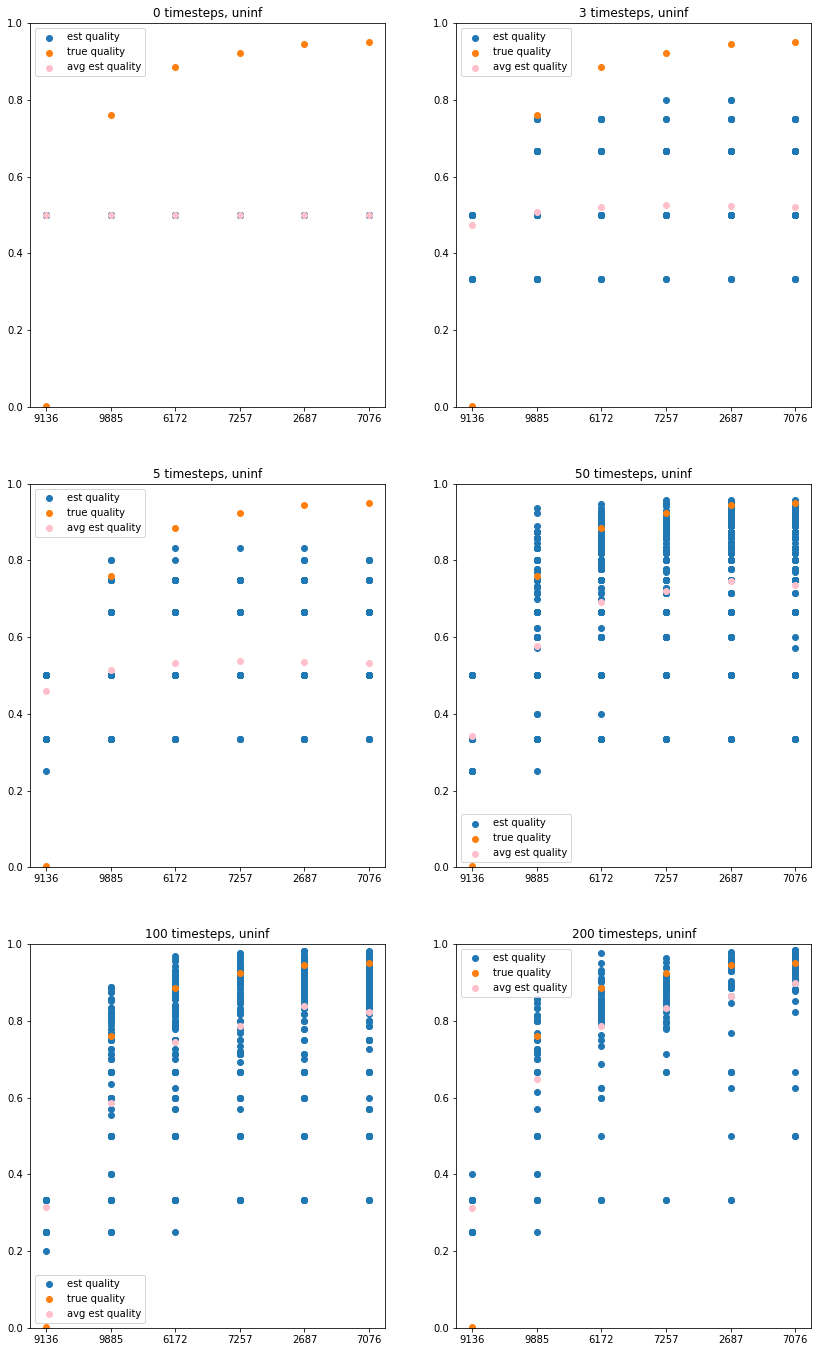

In [211]:
f, axes = plt.subplots(3,2)
f.set_size_inches(14,24)
ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1]]
for i in range(len(ax_path)):
    t = times_of_interest[i]
    plot_quality_scatter(uninf_dict, true_quality, uninf_conf_intervals, videos_of_interest, t, ax=ax_path[i],title=f'{t} timesteps, uninf')
plt.show()

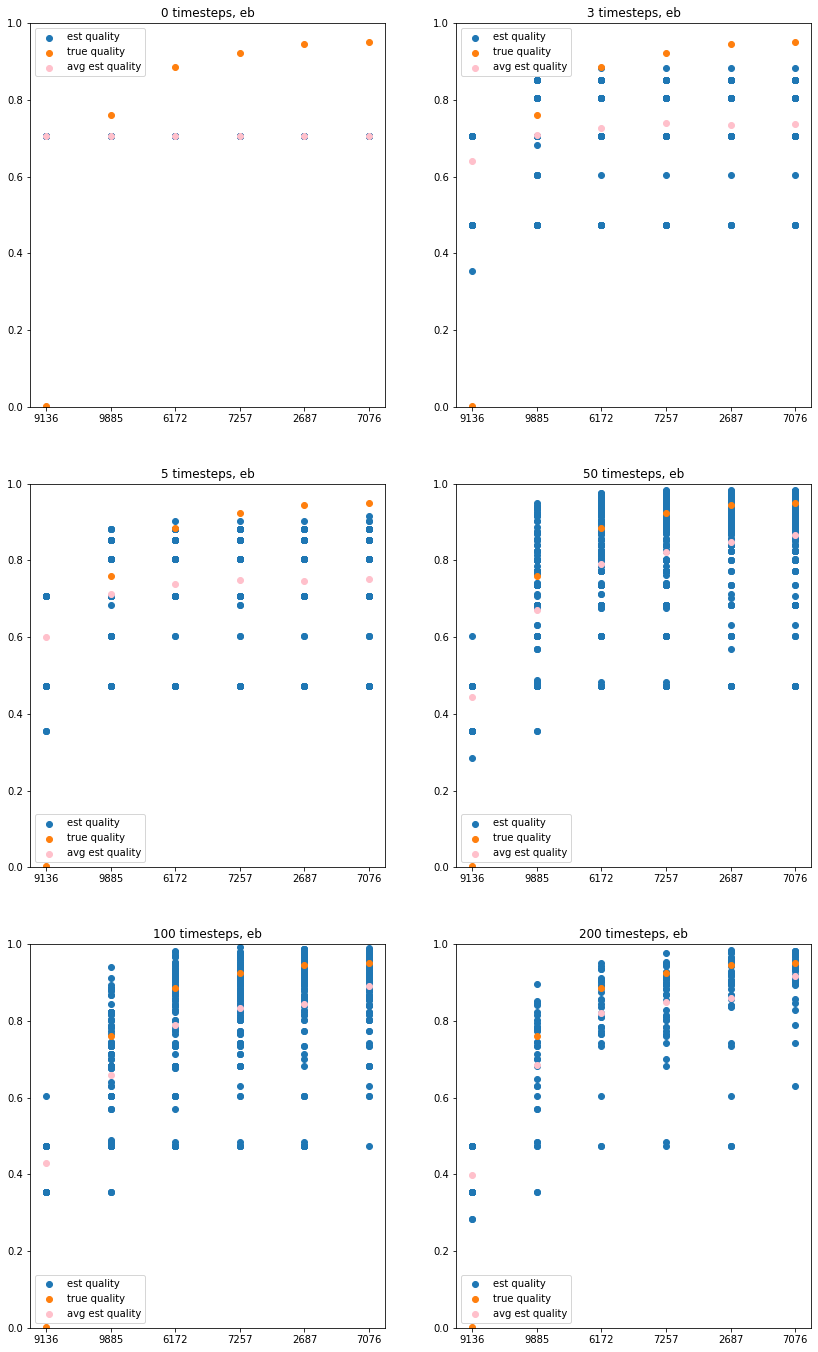

In [212]:
f, axes = plt.subplots(3,2)
f.set_size_inches(14,24)
ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1]]
for i in range(len(ax_path)):
    t = times_of_interest[i]
    plot_quality_scatter(eb_dict, true_quality, eb_conf_intervals, videos_of_interest, t, ax=ax_path[i],title=f'{t} timesteps, eb')
plt.show()

### 5.1 Plot the histogram of plays for each product based on quality

In [213]:
# helper function to pad a one-dimensional array with zeros

def pad_with_zeros(a, target_length):
    if a.shape[0] > target_length:
        raise Exception('array shape exceeds target length')
    else:
        diff = target_length - a.shape[0]
        return np.append(a, np.zeros(target_length - a.shape[0]))

In [214]:
times_of_interest = [0,3,5,10,20,50,100,200]

In [215]:
# todo clean up this section of the code

def plays_per_quality_data(data, videos_dict, times, prior_sum=2):
    plays = dict()
    conf_intervals = dict()
    for prod in videos_dict.keys():
        for time in times:
            value = np.array([data[prod][i][time] for i in range(len(data[prod]))
                        if time < data[prod][i].shape[0]])
            for val in value:
                quality = videos_dict[prod]
                num_plays = np.sum(val)-prior_sum
            
                if (quality,time) not in plays:
                    plays[(quality,time)] = np.array([num_plays])
                else:
                    plays[(quality,time)] = np.concatenate([plays[(quality,time)], [num_plays]])
        
    for k in plays:
        conf_intervals[k] = scipy.stats.sem(plays[k],ddof=0)
        plays[k] = np.mean(plays[k])
                
    return plays, conf_intervals
            

uninf_plays, uninf_plays_conf_intervals = plays_per_quality_data(uninformed_data, test_videos[sampled_videos], times_of_interest)
eb_plays, eb_plays_conf_intervals = plays_per_quality_data(eb_data, test_videos[sampled_videos], times_of_interest, prior_sum=(prior_a+prior_b))

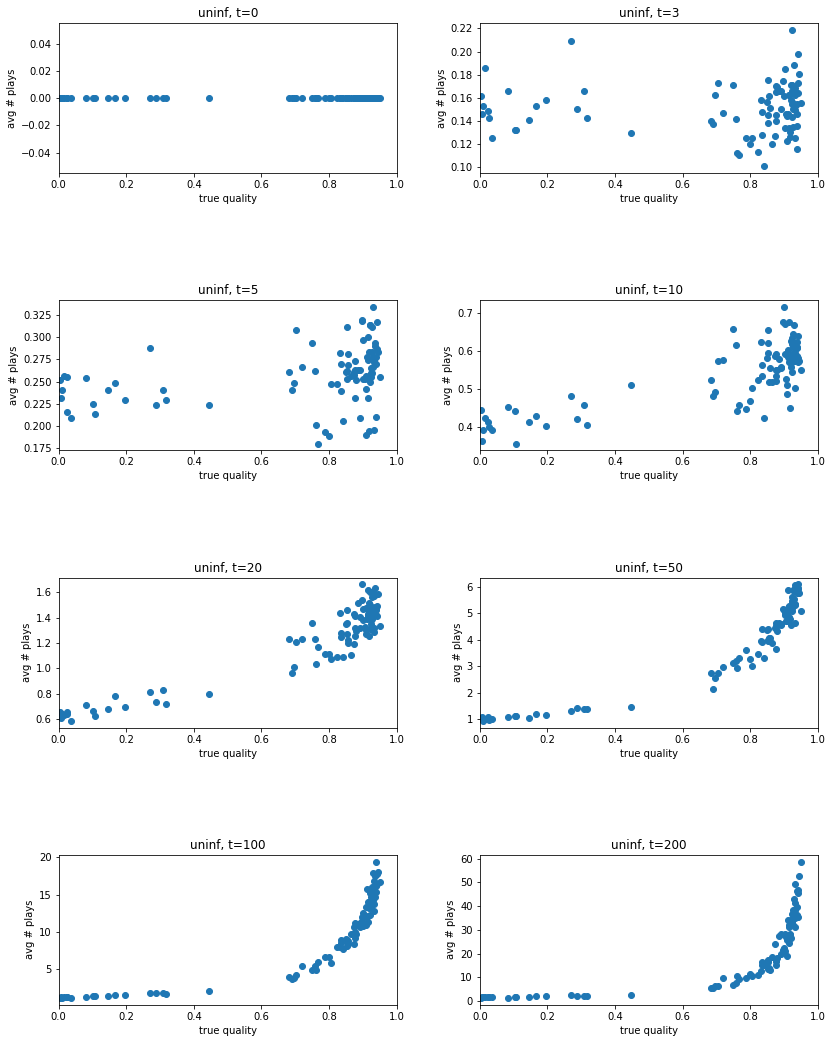

In [238]:
f, axes = plt.subplots(4,2)
f.tight_layout()
f.set_size_inches(12,16)
ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1], axes[3,0], axes[3,1]]
for i in range(len(ax_path)):
    plt.sca(ax_path[i])
    relevant_keys = [k for k in uninf_plays if k[1]==times_of_interest[i]]
    arr = []
    for k in relevant_keys:
        arr.append((k[0], uninf_plays[k], uninf_plays_conf_intervals[k]))
    arr = np.array(arr)
    # plt.errorbar(x=arr[:,0],y=arr[:,1], yerr=arr[:,2], fmt='o')
    plt.scatter(x=arr[:,0],y=arr[:,1])
    plt.xlim((0,1))
    plt.xlabel('true quality')
    plt.ylabel('avg # plays')
    plt.title(f'uninf, t={times_of_interest[i]}')

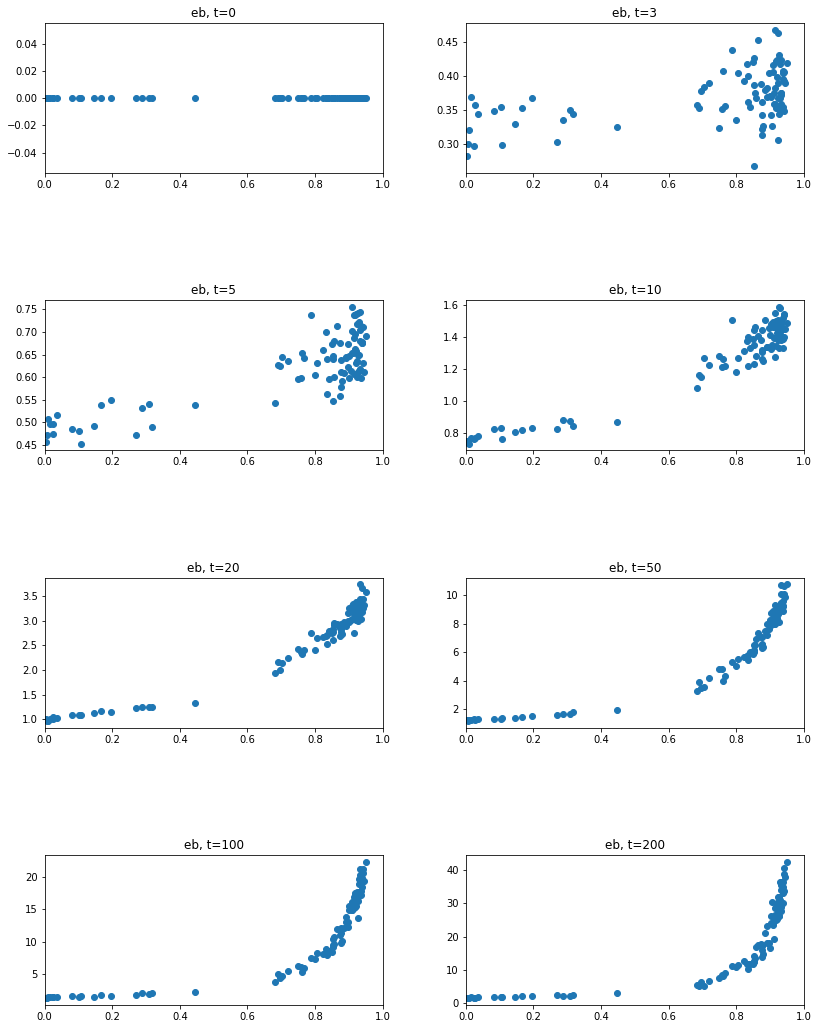

In [239]:
f, axes = plt.subplots(4,2)
f.tight_layout()
f.set_size_inches(12,16)
ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1], axes[3,0], axes[3,1]]
for i in range(len(ax_path)):
    plt.sca(ax_path[i])
    relevant_keys = [k for k in eb_plays if k[1]==times_of_interest[i]]
    arr = []
    for k in relevant_keys:
        arr.append((k[0], eb_plays[k], eb_plays_conf_intervals[k]))
    arr = np.array(arr)
    # plt.errorbar(x=arr[:,0],y=arr[:,1], yerr=arr[:,2], fmt='o')
    plt.scatter(x=arr[:,0],y=arr[:,1])
    plt.xlim((0,1))
    plt.title(f'eb, t={times_of_interest[i]}')

In [243]:
[item[20] for item in uninformed_data[350] if item.shape[0] > 20]

[array([3., 1.]),
 array([2., 1.]),
 array([3., 1.]),
 array([1., 1.]),
 array([2., 1.]),
 array([4., 1.]),
 array([3., 1.]),
 array([1., 1.]),
 array([2., 2.]),
 array([3., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([3., 1.]),
 array([3., 1.]),
 array([2., 2.]),
 array([3., 1.]),
 array([2., 1.]),
 array([2., 1.]),
 array([1., 2.]),
 array([1., 2.]),
 array([3., 1.]),
 array([1., 2.]),
 array([1., 1.]),
 array([1., 2.]),
 array([2., 1.]),
 array([1., 1.]),
 array([4., 2.]),
 array([2., 2.]),
 array([3., 1.]),
 array([2., 1.]),
 array([2., 2.]),
 array([1., 1.]),
 array([4., 1.]),
 array([2., 1.]),
 array([5., 1.]),
 array([2., 1.]),
 array([3., 1.]),
 array([2., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([4., 1.]),
 array([8., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([3., 1.]),
 array([2., 2.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([3., 1.]),
 array([4.

In [218]:
# sanity checking

new_dict = dict()
for k in uninformed_data:
    a = [arr[-1] for arr in uninformed_data[k]]
    a = np.array(a) - np.array([1,1])
    emp_quality = np.sum(a[:,0])/np.sum(a)
    new_dict[k] = emp_quality

new_df = pd.Series(new_dict)

In [219]:
new_df

1926    0.925393
9299    0.837954
1373    0.918600
350     0.897874
4078    0.142506
          ...   
7709    0.110577
7287    0.811404
6251    0.855388
7585    0.027692
9485    0.229282
Length: 100, dtype: float64

In [220]:
test_videos[sampled_videos]

video_id
1926    0.925532
9299    0.832624
1373    0.923459
350     0.890858
4078    0.106308
          ...   
7709    0.102837
7287    0.799433
6251    0.853296
7585    0.015603
9485    0.195606
Name: liked, Length: 100, dtype: float64

## 6 Plot what happens to an out-of-sample good when it enters this marketplace

### 6.1 picking out-of-sample goods

In [221]:
sorted_test_videos = test_videos.sort_values()
print(sorted_test_videos)
sorted_test_videos = np.abs(sorted_test_videos - sorted_test_videos[7257])
print(sorted_test_videos.sort_values())

video_id
10094    0.000709
1170     0.001417
3978     0.002126
7196     0.002126
9136     0.002835
           ...   
9815     0.963855
4040     0.970234
4123     0.971651
5464     0.974468
1305     0.980142
Name: liked, Length: 1331, dtype: float64
video_id
7034     0.000000
674      0.000000
1373     0.000000
7257     0.000000
2666     0.000000
           ...   
9136     0.920624
7196     0.921332
3978     0.921332
1170     0.922041
10094    0.922750
Name: liked, Length: 1331, dtype: float64


In [222]:
out_of_sample_vids = [10094, 7034, 1305] # worst, decent, and best from out-of-sample
any([vid in sampled_videos for vid in out_of_sample_vids])

False

In [223]:
aug_df = dict()
for k in out_of_sample_vids:
    aug_df[k] = kuairec_test[(kuairec_test['video_id'].isin(sampled_videos))|(kuairec_test['video_id']==k)]

In [224]:
second_timesteps = 50 # ideally keep this low so the out-of-sample simulation remains relatively accurate

In [225]:
np.array([uninformed_priors[-1]])

array([[1., 1.]])

In [226]:
def simulate_out_of_sample(chosen_df,
                           snapshots,
                           new_vid,
                           priors,
                           sampling_action,
                           timesteps,
                           num_sims,
                           num_users=1):
    trajectories = []
    for sim in range(num_sims):
        snapshot = copy.deepcopy(snapshots[int(np.random.choice([key for key in snapshots]))])
        curr_vids = snapshot[0] + [new_vid]
        product_data = dict(zip(curr_vids, [[] for _ in range(len(curr_vids))]))
        priors_dict = dict(zip(curr_vids, [priors.copy()[i,:] for i in range(priors.shape[0])]))
        
        
        helper = ProductHelper(product_data, curr_vids, list(curr_vids), priors_dict)
        helper.market = snapshot[1]
        helper.market.append(np.array([copy.deepcopy(priors[-1])]))
        if sim == 0:
            print(len(helper.market))
            print(helper.mkt_ids)
        for t in range(timesteps):
            latest_sims = np.array([item[-1] for item in helper.market])
            successes, failures = latest_sims[:,0], latest_sims[:,1]
            actions = range(len(curr_vids))
            for m in range(num_users):
                a = sampling_action(actions, successes, failures)
                like = sample_chosen_df(curr_vids, chosen_df, a)

                # update prior
                helper.pull_arm_update_market(a, like)
            
        trajectories.append(helper.market[-1])
    
    return trajectories

In [227]:
results_dict = dict()
for vid in out_of_sample_vids:
    for prior_type in ['eb', 'uninf']:
        print(f"now processing {vid}, {prior_type}")
        if prior_type == 'eb':
            priors = eb_priors
            snapshots = eb_snapshots
        else:
            priors = uninformed_priors
            snapshots = uninf_snapshots
        
        results_dict[(vid, prior_type)] = simulate_out_of_sample(kuairec_test,
                                                                 snapshots, 
                                                                 vid,
                                                                 priors,
                                                                 ts_action,
                                                                 second_timesteps,
                                                                 num_sims=100)


now processing 10094, eb
11
[7788, 858, 3935, 9102, 2542, 5865, 4083, 8572, 10330, 10297, 10094]
now processing 10094, uninf
11
[3033, 8707, 6251, 712, 9485, 3652, 7287, 5560, 9022, 7109, 10094]
now processing 7034, eb
11
[9885, 1373, 2235, 640, 1997, 147, 7788, 4702, 7495, 1205, 7034]
now processing 7034, uninf
11
[8572, 614, 1061, 9266, 8707, 7076, 4744, 4226, 712, 7495, 7034]
now processing 1305, eb
11
[929, 712, 5252, 147, 10279, 2572, 640, 10297, 3033, 300, 1305]
now processing 1305, uninf
11
[4078, 6251, 10408, 3876, 9485, 8667, 6172, 10279, 8696, 7495, 1305]


In [228]:
traject_data = copy.deepcopy(dict(zip(results_dict.keys(),[np.array(results_dict[k]) for k in results_dict])))
for k in traject_data:
    traject_data[k] = traject_data[k][:,:,0]/(traject_data[k][:,:,0]+traject_data[k][:,:,1])
    df = pd.DataFrame(traject_data[k]).melt()
    df = df.rename(columns={'variable': 'timestep'})
    traject_data[k] = df

#### Plotting estimated quality over time for new products

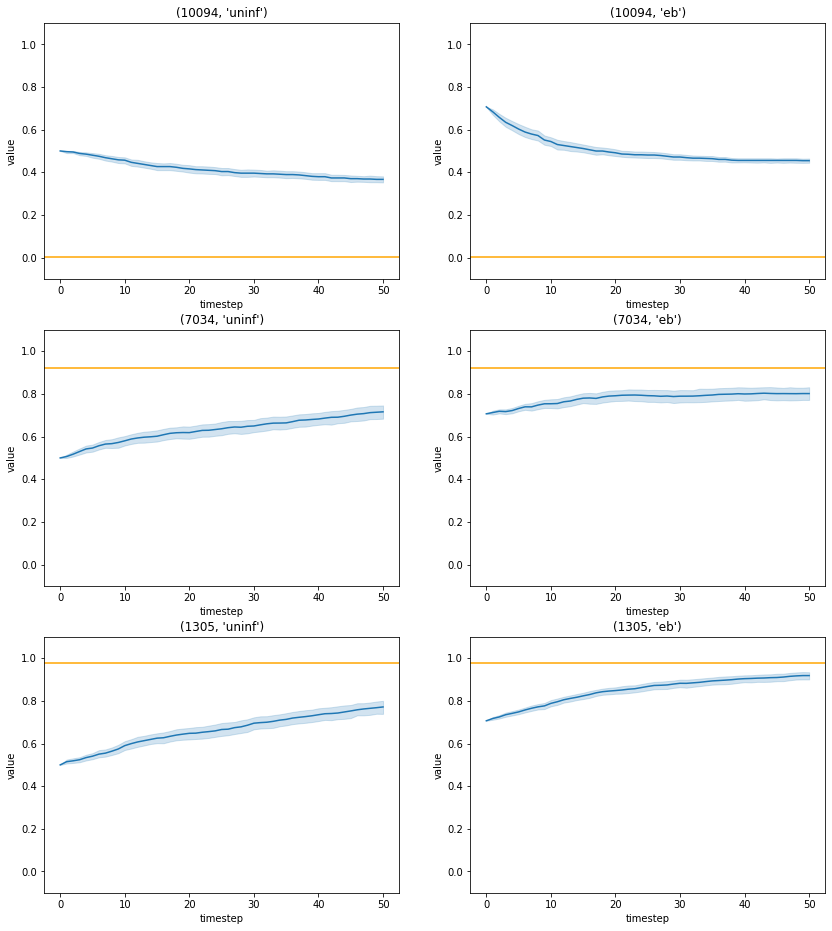

In [229]:
i=0
axis_tuples = [(0,1), (0,0), (1,1), (1,0), (2,1), (2,0)]
f, axes = plt.subplots(3,2)
f.set_size_inches(14,16)
for k in traject_data:
    plt.sca(axes[axis_tuples[i][0], axis_tuples[i][1]])
    plt.ylim(-0.1, 1.1)
#     for j in range(100):
#         plt.plot(results_dict[k][j][:,0]/(results_dict[k][j][:,0]+results_dict[k][j][:,1]),color='blue')
#     plt.axhline(test_videos[k[0]],color='orange')
#     plt.title(k)

    graph = sns.lineplot(traject_data[k],x='timestep',y='value')
    graph.set_title(k)
    graph.axhline(test_videos[k[0]],color='orange')
    i += 1

In [230]:
traject_data = copy.deepcopy(dict(zip(results_dict.keys(),[np.array(results_dict[k]) for k in results_dict])))
for k in traject_data:
    if k[1] == 'eb':
        traject_data[k] = (traject_data[k][:,:,0]+traject_data[k][:,:,1]) - (prior_a + prior_b)
    else:
        traject_data[k] = (traject_data[k][:,:,0]+traject_data[k][:,:,1]) - 2
    df = pd.DataFrame(traject_data[k]).melt()
    df = df.rename(columns={'variable': 'timestep'})
    traject_data[k] = df

#### Plotting number of plays for each product

NameError: name 'avg_eb_plays' is not defined

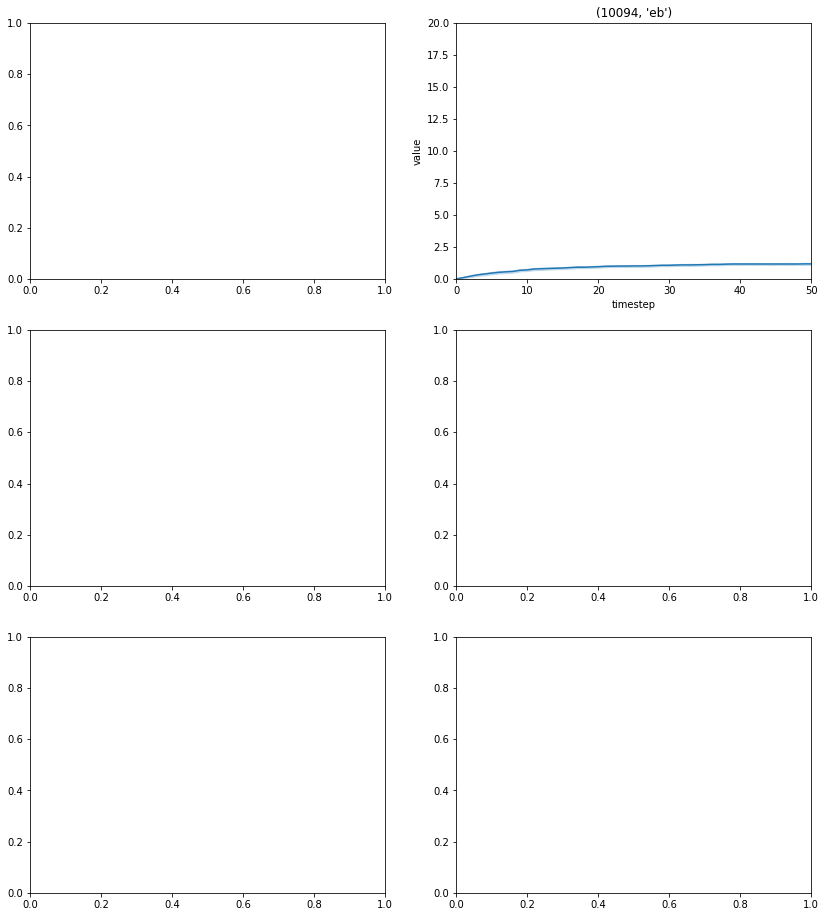

In [231]:
i=0
axis_tuples = [(0,1), (0,0), (1,1), (1,0), (2,1), (2,0)]
f, axes = plt.subplots(3,2)
f.set_size_inches(14,16)
for k in traject_data:
    plt.sca(axes[axis_tuples[i][0], axis_tuples[i][1]])
    plt.ylim(0,20)
    plt.xlim(0,50)
    graph = sns.lineplot(traject_data[k],x='timestep',y='value')
    graph.set_title(k)
    if k[1]=='uninf':
        plt.plot(avg_uninf_plays,color='green')
    else:
        plt.plot(avg_eb_plays,color='green')
    i += 1

In [ ]:
test_videos[7076], test_videos[2687]